## Loading the dataset

In [1]:
from torch_geometric import datasets
import torch 
from torch_geometric.utils import subgraph

dataset = datasets.Planetoid(root = "/home/jik19004/FilesToRun/AdversarialGNN/MIA/blackbox/Shadow", name = "CiteSeer")
data = dataset[0]

labels = data.y
nodes = torch.arange(data.num_nodes)  # Indices of all nodes

In [2]:
import random 
from torch.nn.functional import one_hot 

def generateData(data, graph_sample:float, train_split:float, val_split:float): ## Trivially test would also be part of the split. 
    labels = data.y
    nodes = torch.arange(data.num_nodes)  # Indices of all nodes

    torch.manual_seed(101)  # Set random seed for reproducibility
    num_sampled = int(graph_sample * data.num_nodes)
    
    randomPerm = torch.randperm(data.num_nodes)
    sampled_nodes = nodes[randomPerm[:num_sampled]]
    excluded_nodes = nodes[randomPerm[num_sampled:]] # take the excluded nodes. 
    

    subgraph_edge_index, subgraph_edge_mask = subgraph(
        sampled_nodes, data.edge_index, relabel_nodes=True
    )
    
    excluded_edge_index, excluded_edge_mask = subgraph(
        excluded_nodes, data.edge_index, relabel_nodes = True 
    )

    subgraph_data = data.clone()
    subgraph_data.edge_index = subgraph_edge_index
    subgraph_data.x = data.x[sampled_nodes]
    subgraph_data.y = data.y[sampled_nodes]
    
    excluded_data = data.clone()
    excluded_data.edge_index = excluded_edge_index
    excluded_data.x = excluded_data.x[excluded_nodes]
    excluded_data.y = excluded_data.y[excluded_nodes]
    
    
    train_mask = torch.tensor([False for x in range(len(subgraph_data.x))]) # first initially create it false. 
    false_mask = train_mask.clone() 

    indices = [i for i in range(len(subgraph_data.x))] # the inidices 
    random.shuffle(indices)

    train_len = int(train_split*len(subgraph_data.x)) # take a subset 
    train_mask[indices[:train_len]] = True 

    rem_indices = indices[train_len:].copy() # take the remaining subset. 
    val_len = int(val_split * len(rem_indices)) 
    val_mask = false_mask.clone() 
    val_mask[rem_indices[:val_len]] = True 

    test_indices = rem_indices[val_len:] # the very last indices not used yet. 
    test_mask = false_mask.clone() 
    test_mask[test_indices] = True # take the very last test indices 

    subgraph_data.y = one_hot(subgraph_data.y) # deploy one hot 
    excluded_data.y = one_hot(excluded_data.y)
    subgraph_data.train_mask = train_mask 
    subgraph_data.val_mask = val_mask 
    subgraph_data.test_mask = test_mask 
    
    return subgraph_data, excluded_data 


In [3]:
subgraph_data, excluded_original_nodes = generateData(data, 0.8, 0.25, 0.2)

In [4]:
from torch_geometric.nn import SAGEConv 
import torch.nn.functional as F 

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout 

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Second layer
        x = self.conv2(x, edge_index)
        
        return x ## we're using cross entropy loss so put out the raw logits as output.  
         

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from torch.nn.functional import cross_entropy
import numpy as np 
import pandas as pd 

def Train_and_Evaluate(model, data, epochs, callback, optimizer, device, path = "GraphSage_Citeseer"):
    model.to(device)
    data.to(device) # set to the same device. 
    
    track_call = 0 
    best_val_loss = np.inf # for callback. 
    
    train_losses = [] 
    val_losses = [] 
    
    train_y = data.y[data.train_mask].float()
    val_y = data.y[data.val_mask].float()
    
    len_train = data.y[data.train_mask].shape[0]
    len_val = data.y[data.val_mask].shape[0]
    for i in range(epochs): # go through the epochs.
        train_accuracy = 0 
        val_accuracy = 0 
        
        model.train()
        outputs = model(data) 
        loss = cross_entropy(outputs[data.train_mask], train_y) # evaluate the loss  
        
        output_label = torch.argmax(outputs[data.train_mask], dim = 1)
        train_accuracy = ((output_label == torch.argmax(train_y, dim = 1)).sum())/len_train
        
        loss.backward() # perform backprop and update 
        optimizer.step() 
        loss2 = None 
        
        with torch.no_grad(): 
            model.eval() 
            val_outputs = model(data)
            loss2 = cross_entropy(val_outputs[data.val_mask], val_y) # evaluate for cross entropy 
            
            val_label = torch.argmax(val_outputs[data.val_mask], dim = 1) 
            val_accuracy = ((val_label == torch.argmax(val_y, dim = 1)).sum())/len_val
            
            val_losses.append(loss2.item()) # append the val loss.
            
        print(f"Epoch: {i + 1}, train_loss: {loss.item()}, train_acc: {train_accuracy.item()}, val_loss: {loss2.item()}, val_acc: {val_accuracy.item()}")
        train_losses.append(loss.item())    # append train loss.  
        if loss2.item() <= best_val_loss: 
            best_val_loss = loss2.item() 
            track_call = 0
            torch.save(model, path) # save the model for the best weights. 
        elif loss2.item() > best_val_loss and track_call < callback: 
            track_call +=1 
        else:
            return train_losses, val_losses

In [6]:
from torch.optim import Adam

model = GraphSAGE(in_channels = 3703, hidden_channels = 32, out_channels = 6, dropout = 0.25)
device = torch.device("cuda")
train_losses, val_losses = Train_and_Evaluate(model, subgraph_data, 500, 50, Adam(model.parameters()), device)

Epoch: 1, train_loss: 1.8166007995605469, train_acc: 0.10676691681146622, val_loss: 1.7952275276184082, val_acc: 0.16040100157260895
Epoch: 2, train_loss: 1.7742228507995605, train_acc: 0.2571428716182709, val_loss: 1.7720484733581543, val_acc: 0.24310776591300964
Epoch: 3, train_loss: 1.7342220544815063, train_acc: 0.3864661753177643, val_loss: 1.7455034255981445, val_acc: 0.35087719559669495
Epoch: 4, train_loss: 1.6938663721084595, train_acc: 0.5263158082962036, val_loss: 1.7147444486618042, val_acc: 0.46867167949676514
Epoch: 5, train_loss: 1.643661379814148, train_acc: 0.6676691770553589, val_loss: 1.680830478668213, val_acc: 0.5839598774909973
Epoch: 6, train_loss: 1.5967881679534912, train_acc: 0.7563909888267517, val_loss: 1.644533395767212, val_acc: 0.6265664100646973
Epoch: 7, train_loss: 1.5352783203125, train_acc: 0.7939849495887756, val_loss: 1.6067465543746948, val_acc: 0.6416040062904358
Epoch: 8, train_loss: 1.475706934928894, train_acc: 0.830075204372406, val_loss: 1.5

In [7]:
print(torch.__version__)

1.12.1+cu102


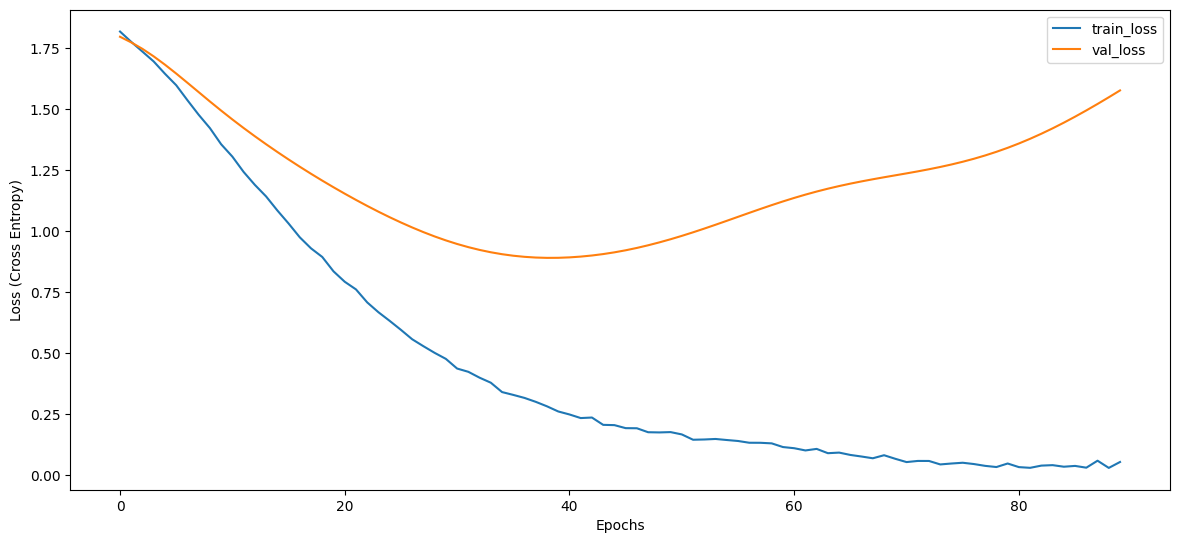

In [8]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize = [5,6])
axes = fig.add_axes(rect = [0,0,2.2,0.8])
axes.plot([i for i in range(len(train_losses))], train_losses, label = "train_loss")
axes.plot([i for i in range(len(val_losses))], val_losses, label = "val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (Cross Entropy)")
axes.legend()

In [9]:
def Evaluate_Test(model, data, test_mask = True):
    model.eval()
    if test_mask: 
        outputs = model(data)[data.test_mask]
        outputs_label = torch.argmax(outputs, dim = 1)
        actual_val = torch.argmax(data.y[data.test_mask], dim = 1)
    else:
        outputs = model(data)
        outputs_label = torch.argmax(outputs, dim = 1)
        actual_val = torch.argmax(data.y, dim = 1)        

    
    print("Test Accuracy: ", ((actual_val == outputs_label).sum())/outputs_label.shape[0])

In [10]:
model = torch.load(r"/home/jik19004/FilesToRun/AdversarialGNN/MIA/blackbox/Shadow/GraphSage_Citeseer")
model.eval() # set it to eval mode. 
outputs = model(subgraph_data)[subgraph_data.test_mask]
outputs_label = torch.argmax(outputs, dim = 1) 
actual_val = torch.argmax(subgraph_data.y[subgraph_data.test_mask], dim = 1)  # take the actual y 

print("Test Accuracy: ", ((actual_val == outputs_label).sum())/outputs_label.shape[0])

Test Accuracy:  tensor(0.7026, device='cuda:0')


# **Shadow Model**

First we take a sample of nodes 

In [11]:
import torch.nn as nn 
class shadowClassifier(torch.nn.Module): 
    def __init__(self, input_size, output_size = 2):
        super(shadowClassifier,self).__init__()
        self.input_size = input_size 
        self.output_size = output_size 
        self.linear_layer = nn.Linear(input_size, output_size, bias = True)
        self.softmax = nn.Softmax()
        
    def forward(self, data):
        x = self.softmax(data)
        x = self.linear_layer(x)
        
        return x ## for the classification. 
        

In [12]:
shadow_data, hold_out_shadowData = generateData(data, graph_sample = 0.6, train_split = 0.7, val_split = 0.2) # generate the shadow data. 
shadow_model = GraphSAGE(in_channels = 3703, hidden_channels = 32, out_channels = 6, dropout = 0.25)

train_losses, val_losses = Train_and_Evaluate(shadow_model, shadow_data, 500, 50, torch.optim.Adam(shadow_model.parameters()), device, "ShadowSage_Citeseer")



Epoch: 1, train_loss: 1.8170892000198364, train_acc: 0.10952039808034897, val_loss: 1.7982732057571411, val_acc: 0.10084034502506256
Epoch: 2, train_loss: 1.7793872356414795, train_acc: 0.23407301306724548, val_loss: 1.7730423212051392, val_acc: 0.1764705926179886
Epoch: 3, train_loss: 1.742781162261963, train_acc: 0.342877596616745, val_loss: 1.7456388473510742, val_acc: 0.3361344635486603
Epoch: 4, train_loss: 1.7040948867797852, train_acc: 0.4674302041530609, val_loss: 1.7153369188308716, val_acc: 0.43697482347488403
Epoch: 5, train_loss: 1.6615382432937622, train_acc: 0.5977093577384949, val_loss: 1.6823123693466187, val_acc: 0.5462185144424438
Epoch: 6, train_loss: 1.6145212650299072, train_acc: 0.7000715732574463, val_loss: 1.6473642587661743, val_acc: 0.605042040348053
Epoch: 7, train_loss: 1.561997652053833, train_acc: 0.7372941970825195, val_loss: 1.6109702587127686, val_acc: 0.6302521228790283
Epoch: 8, train_loss: 1.5095516443252563, train_acc: 0.748031497001648, val_loss: 1

In [13]:
model = torch.load("ShadowSage_Citeseer")
Evaluate_Test(model, shadow_data)

Test Accuracy:  tensor(0.7208, device='cuda:0')


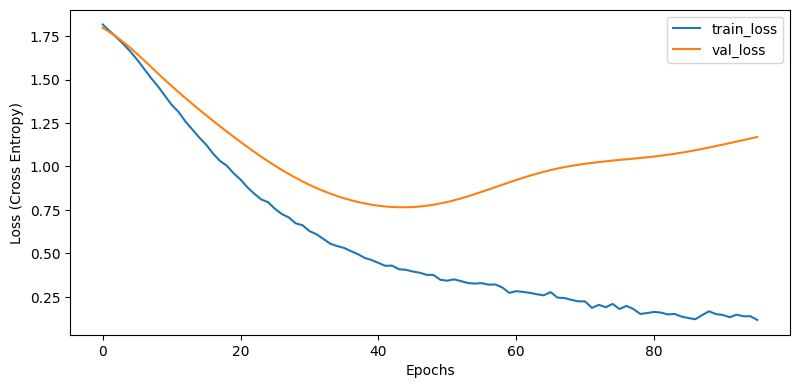

In [14]:
fig = plt.figure(figsize = [4,5])
axes = fig.add_axes(rect = [0,0,1.8,0.65])
axes.plot([i for i in range(len(train_losses))], train_losses, label = "train_loss")
axes.plot([i for i in range(len(val_losses))], val_losses, label = "val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (Cross Entropy)")
axes.legend()

In [15]:
shadow_model = torch.load("/home/jik19004/FilesToRun/AdversarialGNN/MIA/blackbox/Shadow/ShadowSage_Citeseer")
hold_out_shadowData.to(device)
Evaluate_Test(model, hold_out_shadowData, False)

Test Accuracy:  tensor(0.6739, device='cuda:0')


In [16]:
shadow_model.eval()

shadow_train = shadow_model(shadow_data)[shadow_data.train_mask] # get the train 
shadow_test = shadow_model(hold_out_shadowData)

y_shadow_train = [1] * shadow_train.shape[0]
y_shadow_test = [0] * shadow_test.shape[0]

y_train_attack = y_shadow_train + y_shadow_test

shadow_train = shadow_train.detach().cpu().numpy() ## put it to cpu device. 
shadow_test = shadow_test.detach().cpu().numpy()

x_train_attack = np.concatenate((shadow_train,shadow_test)) 

In [17]:
subgraph_data.to(device)
excluded_original_nodes.to(device)

target_train = shadow_model(subgraph_data)[subgraph_data.train_mask]
target_test = shadow_model(excluded_original_nodes)

y_target_train=[1]*target_train.shape[0]
y_target_test=[0]*target_test.shape[0]


target_train_copy = target_train.detach().cpu().numpy()
target_test_copy = target_test.detach().cpu().numpy() 

y_test_attack = y_target_train+y_target_test
x_test_attack = np.concatenate((target_train_copy, target_test_copy)) 
print(x_train_attack.shape)

(2728, 6)


In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
clf = MLPClassifier(random_state=1, solver='adam', max_iter=300).fit(x_train_attack, y_train_attack) 
clf.fit(x_train_attack, y_train_attack) 
print("Test set score: %f" % clf.score(x_test_attack, y_test_attack)) 

y_score = clf.predict(x_test_attack) 
print(metrics.classification_report(y_test_attack, y_score, labels=range(2))) 
print(metrics.roc_auc_score(y_test_attack, y_score)) 

/home/jik19004/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Test set score: 0.694966
              precision    recall  f1-score   support

           0       0.66      0.82      0.73       666
           1       0.76      0.57      0.65       665

    accuracy                           0.69      1331
   macro avg       0.71      0.69      0.69      1331
weighted avg       0.71      0.69      0.69      1331

0.6948745738219423


/home/jik19004/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
